In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [90]:
pd.set_option('display.max_columns', None)

In [91]:
df = pd.read_csv('loan_train.csv',header=0,index_col=0)
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [92]:
df.shape

(58645, 12)

In [93]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

In [94]:
df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [95]:
df['loan_status'].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [96]:
x,y = df.iloc[:,:df.shape[1]-1],df.iloc[:,-1]

In [97]:
categorical_cols = x.select_dtypes(include='object').columns
numerical_cols = x.select_dtypes(include=['float64','int64']).columns

In [98]:
x[numerical_cols] = StandardScaler().fit_transform(x[numerical_cols])

In [99]:
for column in categorical_cols:
    dummies = pd.get_dummies(x[column], prefix=column, drop_first=False, dtype=int)
    x = x.drop(column, axis=1)
    for col in dummies.columns:
        x[col] = dummies[col]

In [100]:
x.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
id,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.566200,-0.765768,-1.187200,-0.578306,0.267616,0.117378,2.031798,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
1,-0.920057,-0.212128,0.328047,-0.937775,0.880532,-0.973242,-0.946489,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0.240196,-0.929223,0.833130,-0.578306,-0.585854,0.553626,1.039036,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
3,0.405947,0.156966,2.348377,0.500101,0.142396,0.117378,-0.201917,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
4,-0.920057,-0.106673,-0.682117,-0.578306,-1.238314,-0.646056,-0.698298,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0


In [101]:
y.head()

id
0    0
1    0
2    0
3    0
4    0
Name: loan_status, dtype: int64

In [102]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [124]:
class TabularDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32).view(-1,1)  # Use long for classification

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [126]:
train_dataset = TabularDataset(x_train, y_train)
test_dataset = TabularDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [127]:
class BinaryTabularNN(nn.Module):
    def __init__(self, input_size):
        super(BinaryTabularNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Binary classification
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [130]:
model = BinaryTabularNN(input_size=x_train.shape[1])  # input_size is the number of features
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

Epoch [1/10], Loss: 0.2274
Epoch [2/10], Loss: 0.1888
Epoch [3/10], Loss: 0.1839
Epoch [4/10], Loss: 0.1820
Epoch [5/10], Loss: 0.1801
Epoch [6/10], Loss: 0.1787
Epoch [7/10], Loss: 0.1760
Epoch [8/10], Loss: 0.1754
Epoch [9/10], Loss: 0.1735
Epoch [10/10], Loss: 0.1737


Accuracy of the model: 94.42%
0.8368944476576055
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     10000
         1.0       0.91      0.68      0.78      1729

    accuracy                           0.94     11729
   macro avg       0.93      0.84      0.88     11729
weighted avg       0.94      0.94      0.94     11729



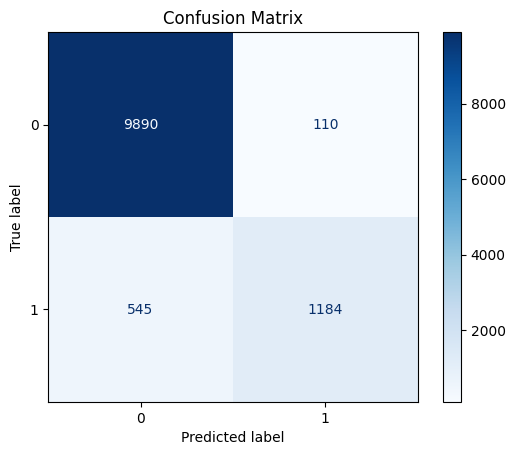

In [140]:
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        probabilities = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        predicted = (probabilities > 0.5).float()  # Convert probabilities to binary predictions
        
        total += labels.size(0)
        correct += (predicted.view(-1) == labels.view(-1)).sum().item()  # Compare with original labels

        all_labels.extend(labels.numpy())  # Collect actual labels
        all_predictions.extend(predicted.numpy())  # Collect predicted labels

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

cm = confusion_matrix(all_labels, all_predictions)

print(f'Accuracy of the model: {100 * correct / total:.2f}%')
print(roc_auc_score(all_labels, all_predictions))
print(classification_report(all_labels, all_predictions))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [141]:
torch.save(model.state_dict(), 'loan_approval.pth')